In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import time

In [ ]:
BATCH_SIZE = 90
EPOCHS = 20
MAX_LR = 1e-3
WEIGHT_DECAY =0.001

In [ ]:
transform = transforms.Compose(
    [#transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5])
     ]
)

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)

torch.manual_seed(26)
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])

#Train
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
#Valid
validloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

#Test
testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
classes = trainset.classes

100%|██████████| 169001437/169001437 [00:05<00:00, 29242169.38it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class simplenet(nn.Module):
    def __init__(self):
      super(simplenet,self).__init__()
      self.classifier = nn.Linear(256,100)

      self.avgpool = nn.AdaptiveAvgPool2d((1,1))

      self.block = nn.Sequential(
          #conv1
          nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),
          #conv2/3/4
          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),
          #Maxpool
          nn.MaxPool2d(kernel_size = 2, stride = 2),
          #conv5/6
          nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),
          #conv7
          nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),
          #Maxpool
          nn.MaxPool2d(kernel_size = 2, stride = 2),
          #conv8/9
          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),
          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),
          #Maxpool
          nn.MaxPool2d(kernel_size = 2, stride = 2),

          #conv10
          nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(512, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),

          #conv11
          nn.Conv2d(512, 2048, kernel_size=1, stride=1, padding=0),
          nn.BatchNorm2d(2048, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),

          #conv12
          nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0),
          nn.BatchNorm2d(256, eps=1e-05, momentum=0.05, affine=True),
          nn.ReLU(),

          #Maxpool
          nn.MaxPool2d(kernel_size = 2, stride = 2),

          #conv13
          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          )
      # for m in self.modules():
      #       if isinstance(m, nn.Conv2d):
      #           nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain("relu"))
    def forward(self, x):
        out = self.block(x)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()

cuda:0


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item())

def train_model_one_epoch(model, trainloader, optimizer,scheduler, device):
    model.train()
    #running_loss = 0.0
    # results = {'loss':[],
    #            'accuracy':[]}
    loss_list= []
    acc_list = []

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #running_loss += loss.item()
        # print statistics

        if i % 100 == 99:    # print every 2000 mini-batches
            # print('[%5d] loss: %.3f' %
            #       (i + 1, running_loss / 70))
            print('>', end = '')
            # running_loss = 0.0


        scheduler.step()

        acc = accuracy(outputs,labels)

        loss_list.append(loss.item())
        acc_list.append(acc.item())
    print('')
    average_loss = sum(loss_list)/len(loss_list)
    total_acc = sum(acc_list)/(BATCH_SIZE*len(acc_list))*100
    lr = get_lr(optimizer)
    # results['accuracy'].append(average_loss)
    # results['loss'].append(average_loss)

    return average_loss,total_acc,lr

def valid_model(model, validloader, device):
    model.eval()
    # results = {'loss':[],
    #            'accuracy':[]}
    loss_list= []
    acc_list = []


    for i, data in enumerate(validloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs =model(inputs)

        loss = criterion(outputs, labels)
        acc = accuracy(outputs,labels)


        loss_list.append(loss.item())
        acc_list.append(acc.item())


        # results['loss'].append(loss)
        # results['accuracy'].append(acc)
    average_loss = sum(loss_list)/len(loss_list)
    average_acc = sum(acc_list)/(BATCH_SIZE*len(acc_list))*100
    #print(f"Current_val_loss: {loss}, val_accuracy:{acc}")
    return average_loss,average_acc

def train_model(model, trainloader,validloader, optimizer,scheduler, num_epochs,device):
    train_perform = {'loss':[],
                     'accuracy':[]}
    valid_perform = {'loss': [],
                      'accuracy':[]}
    best_valid_perform = 0
    start_time = time.time()
    for epoch in range(num_epochs):
        train_loss,train_acc,lr = train_model_one_epoch(model, trainloader, optimizer,scheduler, device)
        train_perform['loss'].append(train_loss)
        train_perform['accuracy'].append(train_acc)

        valid_loss,valid_acc = valid_model(model, validloader, device)
        valid_perform['loss'].append(valid_loss)
        valid_perform['accuracy'].append(valid_acc)
        if best_valid_perform < valid_acc:
            best_valid_perform = valid_acc
            torch.save(model.state_dict(),'/content/data/best_valid.pt')

        print(f'Epoch [{epoch+1}/{num_epochs}] - loss: {train_loss}, accuracy: {train_acc} - val_loss: {valid_loss}, val_accuracy: {valid_acc} - lr :{lr}')

    print('Training time: {:.2f} s'.format(time.time() - start_time))
    return train_perform, valid_perform

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [ ]:
simp = simplenet()
simp.to(device)
optimizer = optim.Adam(simp.parameters(), lr=MAX_LR,weight_decay = WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = MAX_LR, epochs=EPOCHS,
                                                steps_per_epoch=len(trainloader))
train_hist, val_hist = train_model(simp,trainloader,validloader,optimizer,scheduler,EPOCHS,device)

>>>>>
Epoch [1/20] - loss: 3.9207226939201356, accuracy: 11.037777777777778 - val_loss: 3.2653918649469102, val_accuracy: 20.27777777777778 - lr :0.00010434971438817134
>>>>>
Epoch [2/20] - loss: 2.8233182129859924, accuracy: 27.968888888888888 - val_loss: 2.7214414264474596, val_accuracy: 29.04761904761905 - lr :0.0002801451669616888
>>>>>
Epoch [3/20] - loss: 2.3170604784488678, accuracy: 37.65777777777778 - val_loss: 2.763905486890248, val_accuracy: 30.734126984126988 - lr :0.0005202514112045305
>>>>>
Epoch [4/20] - loss: 2.070117667675018, accuracy: 43.25333333333333 - val_loss: 2.482257134148053, val_accuracy: 35.079365079365076 - lr :0.0007602902461173492
>>>>>
Epoch [5/20] - loss: 1.893651313304901, accuracy: 47.217777777777776 - val_loss: 2.5224159147058214, val_accuracy: 34.6031746031746 - lr :0.0009359015447471896
>>>>>
Epoch [6/20] - loss: 1.7847344822883606, accuracy: 50.12 - val_loss: 2.281601297003882, val_accuracy: 39.6031746031746 - lr :0.0009999999496450777
>>>>>
Epoch

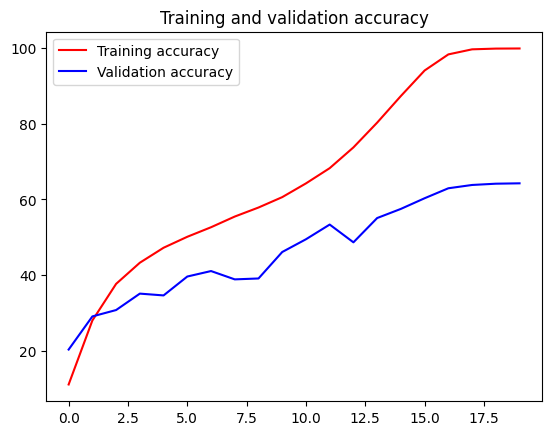

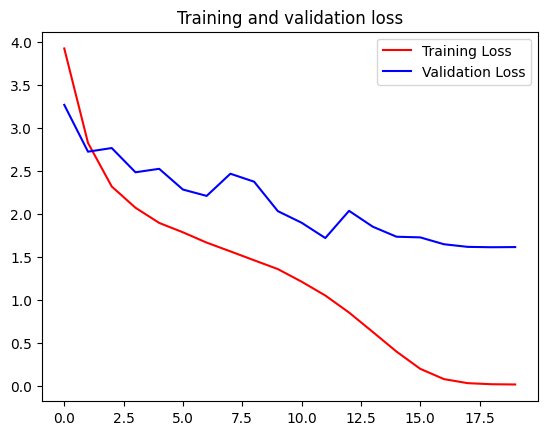

In [ ]:
acc = train_hist['accuracy']
val_acc = val_hist['accuracy']
loss = train_hist['loss']
val_loss = val_hist['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()


plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
shutil.copy("/content/data/best_valid.pt","/content/drive/MyDrive/DeepLearning/Assignment 2/Models selected/Models/simplenet_homemade_20epochs.pt" )

'/content/drive/MyDrive/DeepLearning/Assignment 2/Models selected/Models/simplenet_homemade_20epochs.pt'